## Using scMKL with single-cell RNA and ATAC Data
To run tutorials, install `plotnine` and `jupyter` into you scMKL env with `pip install plotnine jupyter`.

Here, we will run scMKL on a subset of the MCF-7 data (1,000 cells x 36,601 genes for RNA and 1,000 cells x 206,167 peaks for ATAC) using Hallmark groupings.

### Importing Modules
Data is read-in and saved using Numpy and SciPy modules.

In [1]:
import scmkl

# Packages needed to import data
import numpy as np
from scipy.sparse import load_npz

### Reading in Data
There are four pieces of data (per modality) required for scMKL:
- The data matrix itself with cells as rows and features as columns.
    - Can be either a Numpy array or SciPy sparse array (scipy.sparse.csc_array is the recommended format).  
- The sample labels in a Numpy array. To perform group lasso, these labels must be binary.
- Feature names in a Numpy array. These are the names of the features corresponding with the data matrix columns.
- A dictionary with grouping data.  The keys are the names of the groups, and the values are the corresponding features.
    - Example: {Group1: [feature1, feature2, feature3], Group2: [feature4, feature5, feature6], ...}.
    - See `getting_ATAC_groupings.ipynb` and `getting_ATAC_groupings.ipynb` for more information on creating `group_dict`.

In [2]:
# Reading in RNA data
rna_group_dict = np.load('./data/_RNA_hallmark_groupings.pkl', allow_pickle = True)
rna_X = load_npz('./data/_MCF7_RNA_X.npz')
rna_feature_names = np.load('./data/_MCF7_RNA_feature_names.npy', allow_pickle = True)

# Reading in ATAC data
atac_group_dict = np.load('./data/_ATAC_hallmark_groupings.pkl', allow_pickle = True)
atac_X = load_npz('./data/_MCF7_ATAC_X.npz')
atac_feature_names = np.load('./data/_MCF7_ATAC_feature_names.npy', allow_pickle = True)

# Reading in cell labels
cell_labels = np.load('./data/_MCF7_cell_labels.npy', allow_pickle = True)

# This value for D, the number of fourier features in Z, was found to be optimal in previous literature. 
# Generally increasing D increases accuracy and run time.
D = scmkl.calculate_d(len(cell_labels))

### Creating an AnnData Object
scMKL takes advantage of AnnData's flexible structure to create a straight-forward approach to running scMKL. Using `scmkl.create_adata()` will create an AnnData object from input data that will include necessary variables for running scMKL. For more information, see scMKL's [documentation](https://ohsu-cedar-comp-hub.github.io/scMKL/).

In [3]:
# Creating RNA adata
rna_adata = scmkl.create_adata(X = rna_X, feature_names = rna_feature_names, cell_labels = cell_labels, group_dict = rna_group_dict,
                         scale_data = True, D = D, remove_features = True, random_state = 100)

# Creating ATAC adata
atac_adata = scmkl.create_adata(X = atac_X, feature_names = atac_feature_names, cell_labels = cell_labels, group_dict = atac_group_dict,
                         scale_data = False, D = D, remove_features = True, random_state = 100)

In [4]:
rna_adata = scmkl.estimate_sigma(rna_adata, n_features = 200, batch_size= 800, batches = 10)

Specified batch size required too many cells for independent batches. Reduced batch size from 800 to 80


### Optimizing Sparsity
Sparsity (lambda) or alpha here, is the regularization coefficient that controls the pentalty to run with the model. 

This will ultimately decide how many groups will be used in the final model.

`scmkl.optimize_alpha()` returns a single sparsity value as the optimal sparsity argument for training the model.

In [5]:
# Setting a list of alpha values to train the model with
alpha_list = np.round(np.linspace(2.2,0.05,10), 2)

# Calculating the best performing alpha from cross validation on training data
alpha_star = scmkl.optimize_alpha(adata = [rna_adata, atac_adata],
                                              group_size = (2 * D), 
                                              tfidf = [False, False], 
                                              alpha_array = alpha_list, 
                                              k = 4,
                                              batch_size = 60,
                                              batches = 10)

Estimating sigma and calculating Z for adata 0
Estimating sigma and calculating Z for adata 1
Estimating sigma and calculating Z for adata 0
Estimating sigma and calculating Z for adata 1
Estimating sigma and calculating Z for adata 0
Estimating sigma and calculating Z for adata 1
Estimating sigma and calculating Z for adata 0
Estimating sigma and calculating Z for adata 1


### Estimating Kernel Widths, Calculating Z, and Combining Modalities
To estimate kernel widths, calculate Z matrices, and combine the `AnnData` objects for each modality, we use the `multimodal_processing()` function.

In [6]:
combined_adata = scmkl.multimodal_processing(adatas = [rna_adata, atac_adata],
                                             names  = ['RNA', 'ATAC'],
                                             tfidf = [False, False])

Estimating sigma and calculating Z for RNA
Specified batch size required too many cells for independent batches. Reduced batch size from 100 to 80
Estimating sigma and calculating Z for ATAC
Specified batch size required too many cells for independent batches. Reduced batch size from 100 to 80


### Training and Evalutating Model
Here we will train and evaluate 10 models, each with a different `alpha`.

`alpha` (or lambda) is a regularization coefficient that deterimines how many groupings will be used to classify the test cells in the final model. Here, we will evalutate the model using a range of alphas (`alpha_list`) to get a range of selected groups.

In [7]:
results = scmkl.run(combined_adata, alpha_list = alpha_list)
results.keys()

  Evaluating model. Alpha: 2.2
  Evaluating model. Alpha: 1.96
  Evaluating model. Alpha: 1.72
  Evaluating model. Alpha: 1.48
  Evaluating model. Alpha: 1.24
  Evaluating model. Alpha: 1.01
  Evaluating model. Alpha: 0.77
  Evaluating model. Alpha: 0.53
  Evaluating model. Alpha: 0.29
  Evaluating model. Alpha: 0.05


dict_keys(['Metrics', 'Selected_groups', 'Norms', 'Predictions', 'Observed', 'Test_indices', 'Group_names', 'Models', 'Train_time', 'RAM_usage', 'Probabilities'])

### Model Performance and Top Groups per Alpha

In [8]:
summary_df = scmkl.get_summary(results)
summary_df

,Alpha,AUROC,Number of Selected Groups,Top Group
0,2.20,0.9634,6,RNA-HALLMARK_ESTROGEN_RESPONSE_EARLY
1,1.96,0.9716,8,RNA-HALLMARK_ESTROGEN_RESPONSE_EARLY
2,1.72,0.9752,12,RNA-HALLMARK_ESTROGEN_RESPONSE_EARLY
3,1.48,0.9776,13,RNA-HALLMARK_ESTROGEN_RESPONSE_EARLY
4,1.24,0.9798,16,RNA-HALLMARK_ESTROGEN_RESPONSE_EARLY
5,1.01,0.9810,21,RNA-HALLMARK_ESTROGEN_RESPONSE_EARLY
6,0.77,0.9839,27,RNA-HALLMARK_ESTROGEN_RESPONSE_EARLY
7,0.53,0.9859,45,RNA-HALLMARK_ESTROGEN_RESPONSE_EARLY
8,0.29,0.9868,59,RNA-HALLMARK_ESTROGEN_RESPONSE_EARLY
9,0.05,0.9842,75,RNA-HALLMARK_ESTROGEN_RESPONSE_EARLY


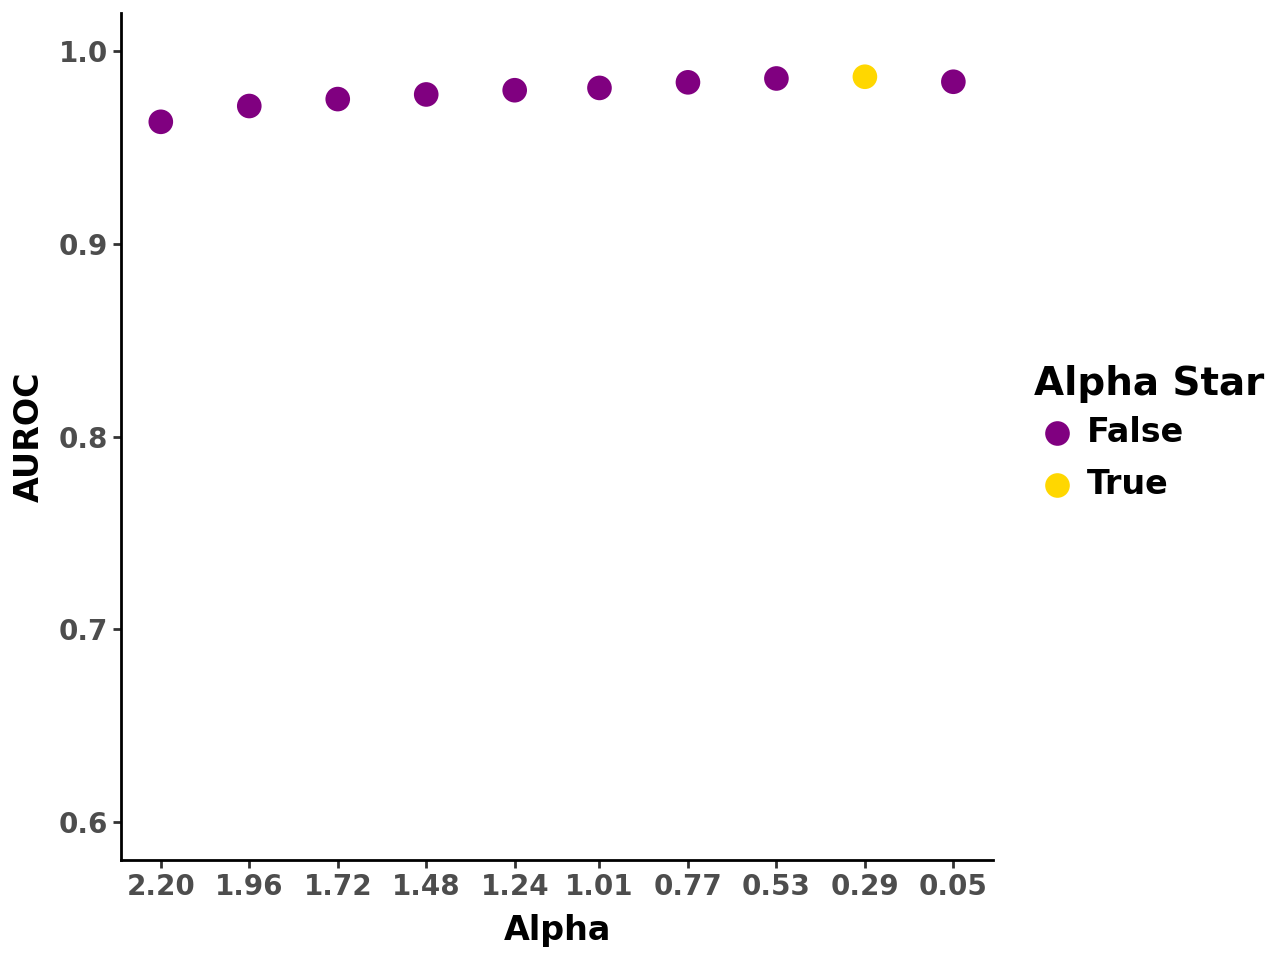

In [9]:
metric_plot = scmkl.plot_metric(summary_df, color = 'purple', alpha_star = alpha_star)
metric_plot.show()

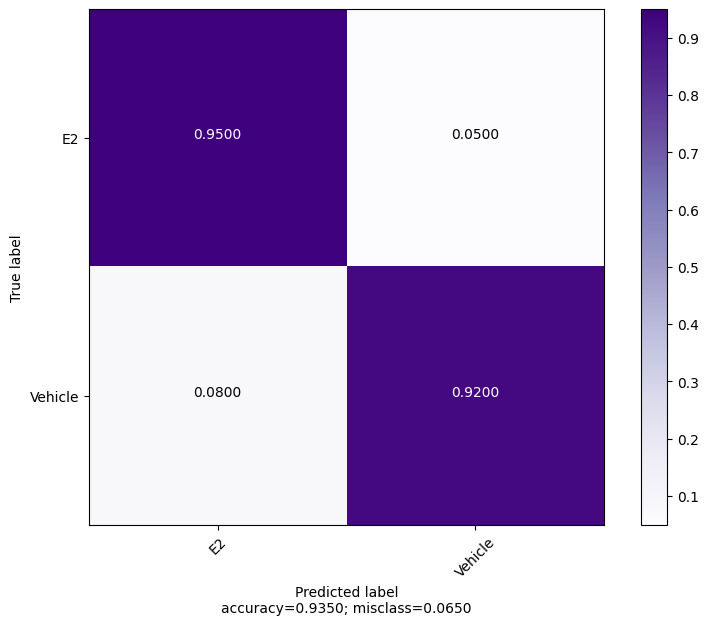

In [10]:
from matplotlib.pyplot import get_cmap

scmkl.plot_conf_mat(results, title = '', cmap = get_cmap('Purples'))